📊 UserSec Threat Data Analysis

In [ ]:
# 1. 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config import collection

# 2. 몽고DB에서 모든 데이터 가져오기
print("데이터를 불러오는 중입니다...")
data = list(collection.find({}, {"_id": 0}))

# 3. 판다스 데이터프레임으로 변환
df = pd.DataFrame(data)

# 4. 데이터 상위 5개만 확인
print(f"총 수집된 메시지 수: {len(df)}개")
df.head()

데이터를 불러오는 중입니다...
총 수집된 메시지 수: 383개


,channel_name,message_id,crawled_at,date,forward_from,is_forwarded,text,text_translated,url,views
0,usersecc,10,2026-01-03 07:52:32.315,2024-10-09 07:07:18,None,False,⚠️ **Снесли канал... Снова!**\n**Судный день U...,⚠️ **채널이 철거되었습니다... 또!**\n**UserSec Doomsday 또...,https://t.me/usersecc/10,13019
1,usersecc,11,2026-01-03 07:52:33.517,2024-10-09 07:29:56,None,False,"Знаю что вы хотите уже в чатик, но нужно потер...",이미 채팅하고 싶은 건 알지만 인내심이 필요합니다,https://t.me/usersecc/11,3022
2,usersecc,13,2026-01-03 07:52:34.544,2024-10-09 12:31:34,None,False,🟩 **Новый контакт для связи: ****@russ_user1**,🟩 **새 커뮤니케이션 연락처: ****@russ_user1**,https://t.me/usersecc/13,2278
3,usersecc,14,2026-01-03 07:52:35.581,2024-10-09 12:35:47,None,False,"👉 **Открыт чат, друзья! \n****@usersec_chatt**","👉 **친구 여러분, 채팅이 열려 있습니다! \n****@usersec_chat**",https://t.me/usersecc/14,2388
4,usersecc,15,2026-01-03 07:52:36.608,2024-10-09 12:59:18,None,False,✈️ **Все важные контакты восстановлены! Сейчас...,✈️ **중요한 연락처가 모두 복원되었습니다! 이제 우리의 실천 계획을 말씀드리겠습...,https://t.me/usersecc/15,2716


## 1. Daily Activity Trend

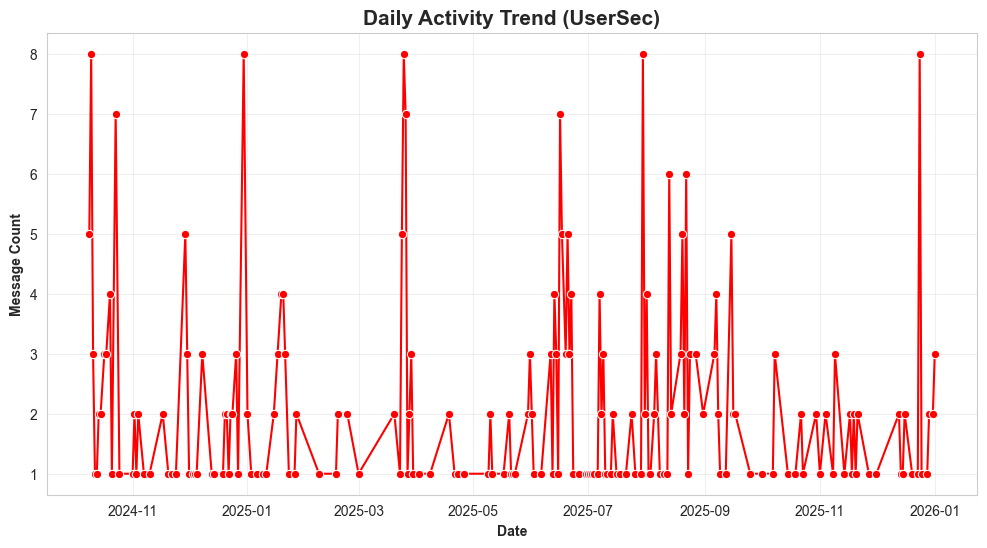

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 날짜 데이터 전처리 (Timezone 변환)
# 몽고DB의 date 컬럼을 datetime 객체로 변환
df['date'] = pd.to_datetime(df['date'])

# UTC 시간을 동호주 시간(AEST)으로 변환 (+10시간)
df['date_aest'] = df['date'] + pd.Timedelta(hours=10)

# 2. '날짜(YYYY-MM-DD)'만 추출해서 카운팅
daily_counts = df['date_aest'].dt.date.value_counts().sort_index()

# 3. 그래프 그리기
plt.figure(figsize=(12, 6)) # 그래프 크기 설정
sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker='o', color='red')

plt.title('Daily Activity Trend (UserSec)', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Message Count', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.show()

## 2. Activity Time Analysis (MSK vs UTC)

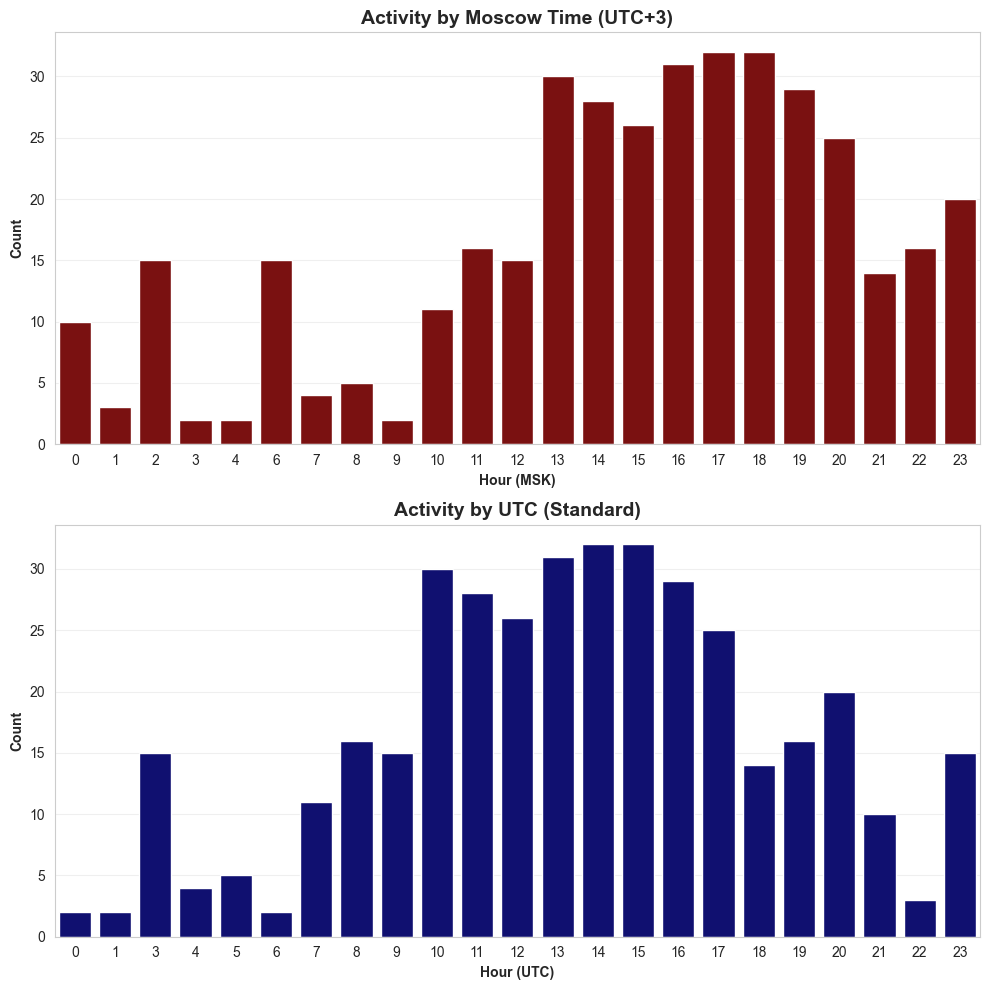

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비
df['hour_msk'] = (df['date'] + pd.Timedelta(hours=3)).dt.hour  # 모스크바
df['hour_utc'] = df['date'].dt.hour                            # UTC (표준)

# 그래프 그리기 (두 개를 위아래로 비교)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# 1. 모스크바 시간 기준
sns.countplot(x='hour_msk', data=df, ax=axes[0], color='darkred')
axes[0].set_title('Activity by Moscow Time (UTC+3)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour (MSK)', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 2. UTC 시간 기준
sns.countplot(x='hour_utc', data=df, ax=axes[1], color='navy')
axes[1].set_title('Activity by UTC (Standard)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour (UTC)', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Threat Topic Analysis

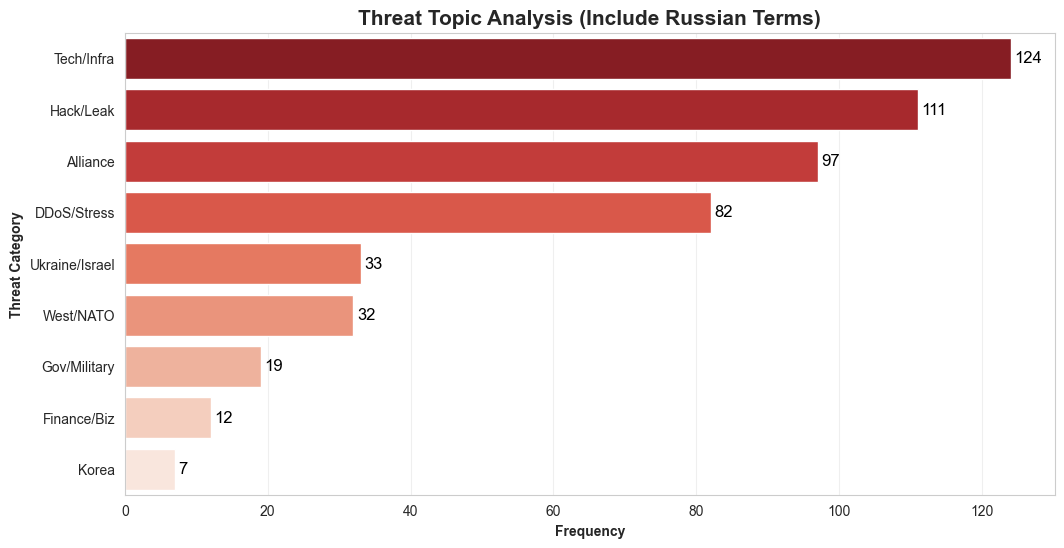

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 감시할 키워드 사전 정의 (어근 검색 최적화 반영)
keyword_map = {
    # Category: [English, Russian]
    # 1. 공격 유형 (Method)
    'DDoS/Stress': ['ddos', 'ддос', 'attack', 'атак', 'kill', 'stress', 'down', 'упал', 'лежит', 'ложи'],
    'Hack/Leak': ['hack', 'взлом', 'leak', 'слив', 'data', 'данн', 'access', 'доступ', 'deface'],    
    
    # 2. 기술 스택 (Tech & Infra)
    'Tech/Infra': ['rtsp', 'vnc', 'cctv', 'cam', 'server', 'сервер', 'unix', 'linux', 'bot', 'бот'],
    
    # 3. 공격 타겟 - 국가 (Geopolitics)
    'Korea': ['korea', 'коре', 'kr', 'seoul', 'сеул', 'kisa'],
    'West/NATO': ['usa', 'сша', 'nato', 'нато', 'eu', 'europe', 'german', 'немец', 'deutsc'],
    'Ukraine/Israel': ['ukrain', 'украин', 'israel', 'израил'],
    
    # 4. 공격 타겟 - 섹터 (Sector)
    'Gov/Military': ['gov', 'правительств', 'militar', 'army', 'военн', 'mfa'],
    'Finance/Biz': ['bank', 'банк', 'money', 'pay', 'plat', 'плат', 'swift', 'bitcoin', 'биткоин'],
    
    # 5. 연대/동맹 (Alliance)
    'Alliance': ['killnet', 'килнет', 'anonymous', 'legion', 'revil', 'usersec']
}

# 2. 카운팅 로직 (대소문자 무시)
counts = {}
for category, words in keyword_map.items():
    # 여러 단어 중 하나라도 포함되면 카운트 (OR 조건)
    pattern = '|'.join(words) 
    counts[category] = df['text'].str.contains(pattern, case=False, regex=True).sum()

# 3. 데이터프레임 변환 및 정렬
kw_df = pd.DataFrame(list(counts.items()), columns=['Category', 'Count'])
kw_df = kw_df.sort_values(by='Count', ascending=False)

# 4. 막대 그래프 그리기
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=kw_df,
                 hue='Category', palette='Reds_r', legend=False)

plt.title('Threat Topic Analysis (Include Russian Terms)', fontsize=15, fontweight='bold')
plt.xlabel('Frequency', fontweight='bold')
plt.ylabel('Threat Category', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# 막대 옆에 숫자 표시
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 0.5,
                p.get_y() + p.get_height() / 2,
                f'{int(width)}', 
                ha='left', va='center', fontsize=12, color='black')

plt.show()

## 4. Threat Keyword Frequency

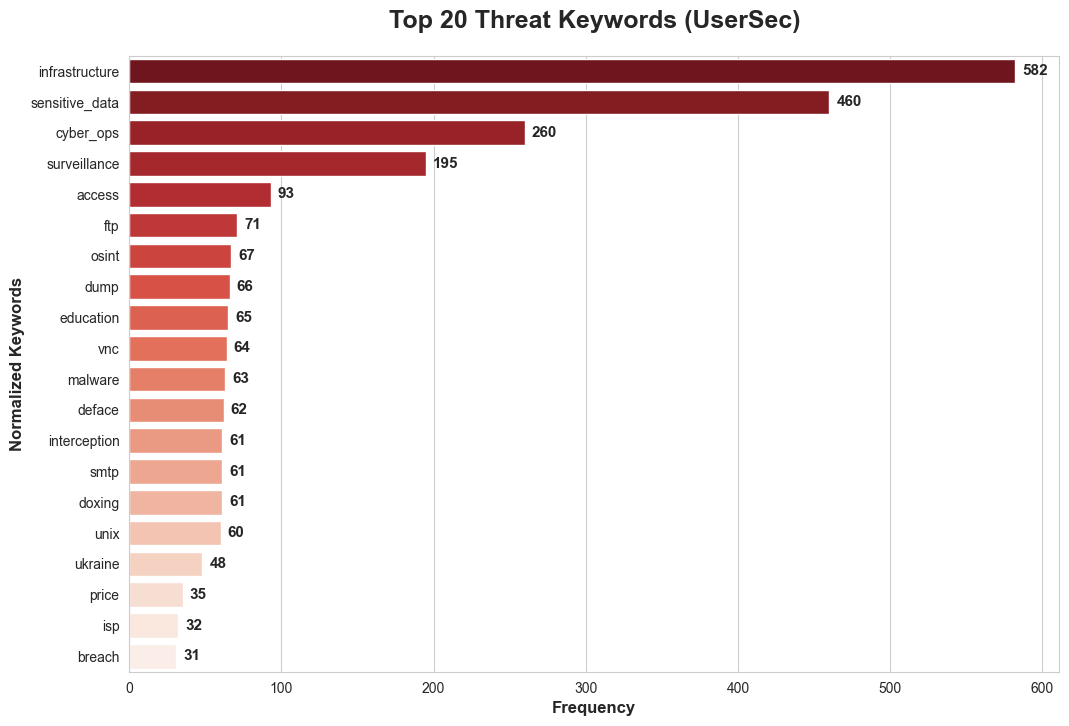

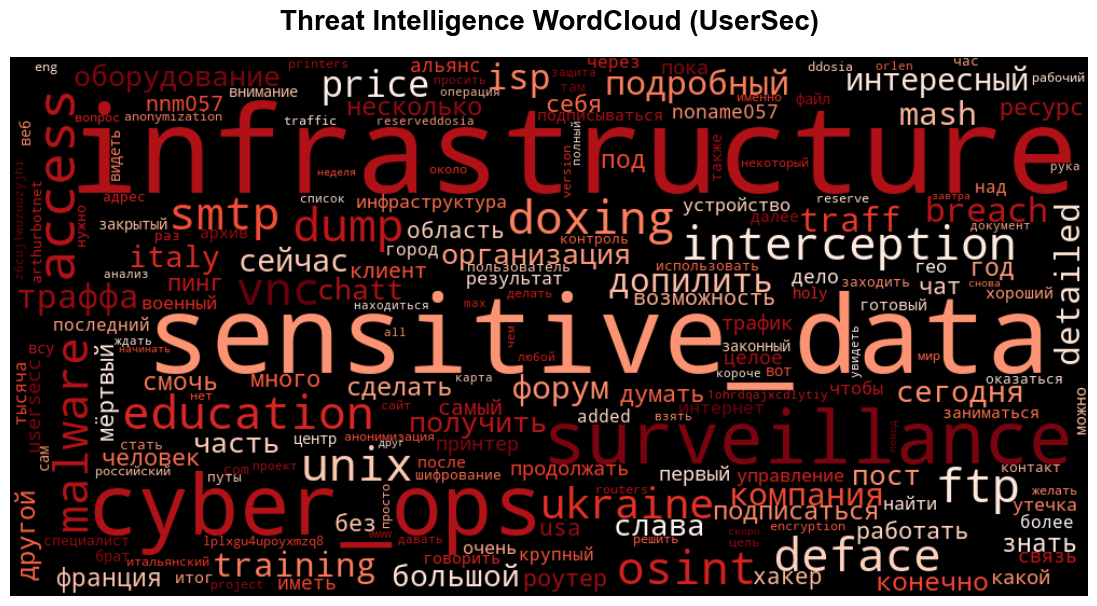

In [102]:
import inspect
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt  
import seaborn as sns            
import pandas as pd              

# ==========================================
# 1. [필수] pymorphy2 호환성 패치
# ==========================================
if not hasattr(inspect, 'getargspec'):
    def _getargspec_shim(func):
        spec = inspect.getfullargspec(func)
        return (spec.args, spec.varargs, spec.varkw, spec.defaults)
    inspect.getargspec = _getargspec_shim

import pymorphy2 
morph = pymorphy2.MorphAnalyzer()

# ==========================================
# 2. [설정] 커스텀 매핑 & 불용어
# ==========================================
# 커스텀 매핑: 같은 뜻의 단어들을 대표 영단어 하나로 통합
custom_map = {
    # 핵심 위협
    'камера': 'surveillance', 'camera': 'surveillance', 'cameras': 'surveillance',
    'cctv': 'surveillance', 'видеонаблюдение': 'surveillance', 'rtsp': 'surveillance',
    # 공격 유형
    'взлом': 'cyber_ops', 'hacking': 'cyber_ops', 'атака': 'cyber_ops',
    'attack': 'cyber_ops', 'attacks': 'cyber_ops',
    'dos': 'cyber_ops', 'ddos': 'cyber_ops', 'кибероперация': 'cyber_ops',
    'доступ': 'access', 'попасть': 'breach', 'деанон': 'doxing', 'deanon' : 'doxing',
    'перехват': 'interception', 'малваря': 'malware',
    # 데이터 관련
    'личный': 'sensitive_data', 'private': 'sensitive_data',
    'данные': 'sensitive_data', 'data': 'sensitive_data',
    'база': 'sensitive_data', 'database': 'sensitive_data', 'databases': 'sensitive_data',
    'материал': 'sensitive_data', 'material': 'sensitive_data', 'materials': 'sensitive_data',
    'информация': 'sensitive_data', 'information': 'sensitive_data',
    'выгрузка': 'dump', 'unloading': 'dump',
    'осинт': 'osint',
    # 인프라 관련
    'сервер': 'infrastructure', 'server': 'infrastructure', 'servers': 'infrastructure',
    'система': 'infrastructure', 'system': 'infrastructure', 'systems': 'infrastructure',
    'сеть': 'infrastructure', 'net': 'infrastructure',
    'host': 'infrastructure',
    # 국가
    'корея': 'korea', 'сша': 'usa', 'нато': 'nato',
    'украина': 'ukraine', 'украинский': 'ukraine', 'италия': 'italy',
    # 기타
    'прайс': 'price', 'провайдер': 'isp', 'обучение': 'education'
}

# 불용어 정의: 기본 + 노이즈 + 스팸성 문구
stop_words = set([
    # English
    'the', 'an', 'in', 'on', 'at', 'to', 'of', 'and', 'or', 'is', 'are', 'was', 'were',
    'for', 'with', 'by', 'from', 'it', 'this', 'that', 'you', 'we', 'our', 'us', 'me',  
    'have', 'has', 'been', 'want', 'can', 'get', 'check', 'report', 'announce', 'now',
    'http', 'https', 'net', 'join', 'subscribe', 'write', 'click', 'course', 'channel', 'group',
    'new', 'messages', 'completed', 'updated', 'work', 'each', 'about', 'into', 'target', 'country',
    'russia', 'glorytorussia', 'russ', 'user1', 'usersec', 'killnet', 'comrade', 'comrades',

    # Russian
    'что', 'кто', 'они', 'она', 'это', 'этот', 'тот', 'нас', 'наш', 'ваш', 'вам', 'нам',
    'свой', 'как', 'так', 'такой', 'для', 'или', 'если', 'всё', 'весь', 'уже', 'ещё', 'теперь',
    'где', 'когда', 'только', 'который', 'каждый', 'новый', 'быть', 'есть', 'хотеть', 'мочь',
    'дать', 'писать', 'место', 'время', 'день', 'один', 'курс', 'канал', 'группа', 
    'россия', 'страна', 'сообщение', 'работа', 'обновть', 'объявить', 'целевой', 'товарищ'
])

# ==========================================
# 3. [함수] 전처리 로직
# ==========================================
def clean_and_tokenize(text):
    if not isinstance(text, str): return []
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9]', ' ', text).lower()
    words = text.split()
    cleaned_words = []
    
    for w in words:
        # [전처리 1] 사전적 기본형(Lemma)로 통합
        w = w.strip('-_—.') # strip 제거
        if not w: continue

        parsed = morph.parse(w)[0]
        lemma = parsed.normal_form

        final_word = custom_map.get(lemma, lemma) # 커스텀 매핑
  
        # [전처리 2] 필터링: 불용어, 2글자 이하, 숫자조합 제외
        if (final_word not in stop_words and 
            len(final_word) > 2 and 
            not final_word.isdigit()):

            cleaned_words.append(final_word)

    return cleaned_words

# ==========================================
# 4. [실행] 데이터 분석
# ==========================================
all_words = []

for text in df['text']:
    if pd.isna(text) or text is None: continue
    cleaned = clean_and_tokenize(str(text))
    all_words.extend(cleaned)

word_counts = Counter(all_words) # 빈도 계산

# ==========================================
# 5. [시각화 1] 막대 그래프 (Bar Chart)
# ==========================================
top_20 = word_counts.most_common(20)
df_plot = pd.DataFrame(top_20, columns=['Keyword', 'Frequency'])

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

ax = sns.barplot(x='Frequency', y='Keyword', data=df_plot, 
                 hue='Keyword', palette='Reds_r', legend=False)

plt.title('Top 20 Threat Keywords (UserSec)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Frequency', fontweight='bold', fontsize=12)
plt.ylabel('Normalized Keywords', fontweight='bold', fontsize=12)

# 막대 끝에 숫자 표시
for container in ax.containers:
    ax.bar_label(container, padding=5, fmt='%d', fontsize=11, fontweight='bold')

plt.show()

# ==========================================
# 6. [시각화 2] 워드 클라우드 (Word Cloud)
# ==========================================
wordcloud = WordCloud(
    width=1000, 
    height=500, 
    background_color='black',
    colormap='Reds',
    stopwords=stop_words
).generate_from_frequencies(word_counts)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Threat Intelligence WordCloud (UserSec)', fontsize=20, fontweight='bold', color='black', pad=20)
plt.show()

## 5. IOC Analysis

⏳ IOC 추출 중...
✅ 총 100개의 침해 지표(IOC)가 추출되었습니다.
----------------------------------------
       count
Type        
URL       88
IPv4       8
BTC        2
Email      2


C:\Users\asoun\AppData\Local\Temp\ipykernel_10108\776372905.py:93: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:silver'` for the same effect.

  ax = sns.barplot(x='Count', y='IOC_Value', data=top_iocs, color='silver',


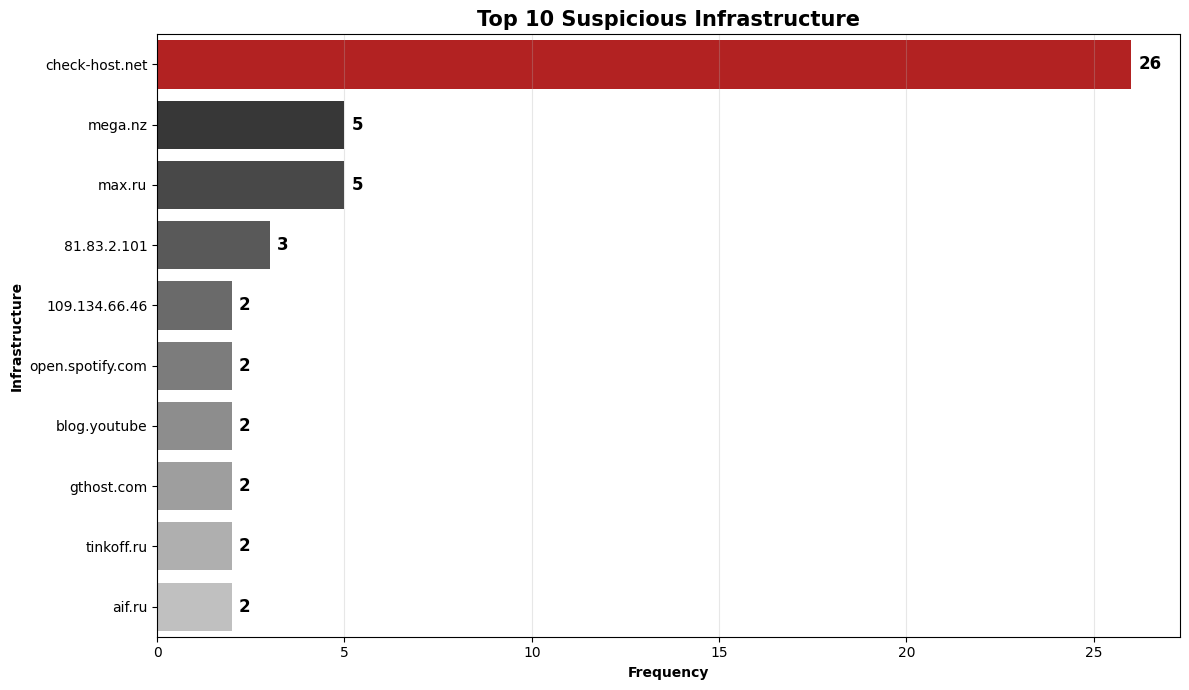

✅ 전체 IOC 100건 저장 완료: extracted_iocs.csv


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ==========================================
# 1. [설정] IOC 추출을 위한 정규식 패턴 정의
# ==========================================
ioc_patterns = {
    'IPv4': r'\b(?:\d{1,3}\.){3}\d{1,3}\b',
    'URL': r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+',
    'Email': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
    'BTC': r'\b(?:bc1|[13])[a-zA-HJ-NP-Z0-9]{25,39}\b'
}

# ==========================================
# 2. [실행] 텍스트에서 IOC 추출
# ==========================================
print("⏳ IOC 추출 중...")

ioc_data = []

for index, row in df.iterrows():
    text = str(row['text'])

    text_clean = text.replace('\n', ' ').replace('\r', ' ') # 분석용
    evidence_text = text_clean                              # 엑셀 저장용

    if not text or pd.isna(text): continue
    
    # 1. URL 먼저 추출
    urls = re.findall(ioc_patterns['URL'], text_clean)
    for url in urls:
        if 't.me' in url: continue

        ioc_data.append({
            'Date': row['date'],
            'Type': 'URL',
            'Value': url,
            'Source_Channel': row.get('forward_from', 'Unknown'),
            'Original_Message': evidence_text,
            'Link': row.get('url')
        })
        # 중복 방지
        text_clean = text_clean.replace(url, ' ' * len(url))

    # 2. IP, Email, BTC 추출
    for ioc_type, pattern in ioc_patterns.items():
        if ioc_type == 'URL': continue

        matches = re.findall(pattern, text_clean)
        for match in matches:
            # IPv4 노이즈 필터링
            if ioc_type == 'IPv4':
                if match.startswith('127.') or match.startswith('0.'): continue            

            ioc_data.append({
                'Date': row['date'],
                'Type': ioc_type,
                'Value': match,
                'Source_Channel': row.get('forward_from', 'Unknown'),
                'Original_Message': evidence_text,
                'Link': row.get('url')
            })

# 결과를 데이터프레임으로 변환
ioc_df = pd.DataFrame(ioc_data)

print(f"✅ 총 {len(ioc_df)}개의 침해 지표(IOC)가 추출되었습니다.")
if not ioc_df.empty:
    print("-" * 40)
    print(ioc_df['Type'].value_counts().to_frame())

# ==========================================
# 3. [시각화] 주요 위협 인프라 분석
# ==========================================
if not ioc_df.empty:
    # 원본 값 보호를 위해 복사본 생성
    plot_df = ioc_df[ioc_df['Type'] == 'URL'].copy()
    
    if not plot_df.empty:
        # 정규화: 도메인만 남김
        plot_df['Clean_Value'] = plot_df['Value'].str.replace(r'^https?://', '', regex=True)
        plot_df['Clean_Value'] = plot_df['Clean_Value'].str.replace(r'^www\.', '', regex=True)
        plot_df['Clean_Value'] = plot_df['Clean_Value'].str.rstrip('/')
    
        top_iocs = plot_df['Clean_Value'].value_counts().head(10).reset_index()
        top_iocs.columns = ['IOC_Value', 'Count']

        # 그래프 그리기
        plt.figure(figsize=(12, 7))

        ax = sns.barplot(x='Count', y='IOC_Value', data=top_iocs, color='silver',
                         hue='IOC_Value', legend=False)
        
        ax.patches[0].set_facecolor('firebrick')
    
        plt.title('Top 10 Suspicious Infrastructure', fontsize=15, fontweight='bold')
        plt.xlabel('Frequency', fontweight='bold')
        plt.ylabel('Infrastructure', fontweight='bold')
        plt.grid(axis='x', alpha=0.3)

        for container in ax.containers:
            ax.bar_label(container, padding=5, fmt='%d', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ 발견된 URL이 없습니다.")

    # ==========================================
    # 4. [저장] 엑셀 저장
    # ==========================================
    # 줄바꿈 제거
    cols_to_clean = ['Original_Message', 'Source_Channel', 'Value']
    for col in cols_to_clean:
        if col in ioc_df.columns:
            ioc_df[col] = ioc_df[col].astype(str).str.replace(r'[\r\n\t]+', ' ', regex=True)

    ioc_df.to_csv('extracted_iocs.csv', index=False, encoding='utf-8-sig')
    print(f"✅ 전체 IOC {len(ioc_df)}건 저장 완료: extracted_iocs.csv")

else:
    print("⚠️ 추출된 IOC가 없습니다.")